In [1]:
# Google Colaboratoryを使用する場合は、下記のコメントアウトを外し、実行してください

In [2]:
# # 下記セルを実行すると、authorization codeの入力を求められます。
# # 出力されたリンク先をクリックし、Googleアカウントにログインし、
# # authorization codeをコピーし、貼り付けをおこなってください。
# import os
# from google.colab import drive
# drive.mount('/content/drive')

In [3]:
# working_dir = 'MLSys_100Knocks' #　※※自分で作成したフォルダパスが異なる場合こちらを変更してください。※※
# path = f'/content/drive/MyDrive/{working_dir}/本章/8章'
# os.chdir(path)
# ! pip install japanize-matplotlib

# ８章 構築した機械学習モデルで新規データを予測する１０本ノック



### ノック７１：フォルダ生成をしてデータ読み込みの準備をしよう

In [1]:
import os
data_dir = 'data'
input_dir = os.path.join(data_dir, '0_input')
output_dir = os.path.join(data_dir, '1_output')
master_dir = os.path.join(data_dir, '99_master')
model_dir = 'models'
os.makedirs(input_dir,exist_ok=True)
os.makedirs(output_dir,exist_ok=True)
os.makedirs(master_dir,exist_ok=True)
os.makedirs(model_dir,exist_ok=True)

##### ＊＊必ずデータやモデルの配置をおこなってください。＊＊

### ノック７２：予測したい新規データを読み込もう

In [2]:
import pandas as pd
m_area_file = 'm_area.csv'
m_store_file = 'm_store.csv'
m_area = pd.read_csv(os.path.join(master_dir, m_area_file))
m_store = pd.read_csv(os.path.join(master_dir, m_store_file))

In [3]:
tg_ym = "202003"
target_file = "tbl_order_" + tg_ym + ".csv"
target_data = pd.read_csv(os.path.join(input_dir, target_file))

import datetime
max_date = pd.to_datetime(target_data["order_accept_date"]).max()
min_date = pd.to_datetime(target_data["order_accept_date"]).min()
max_str_date = max_date.strftime("%Y%m")
min_str_date = min_date.strftime("%Y%m")
if tg_ym == min_str_date and tg_ym == max_str_date:
    print("日付が一致しました")
else:
    raise Exception("日付が一致しません")

日付が一致しました


### ノック７３：新規データを店舗別で集計しよう

In [4]:
def calc_delta(t):
    t1, t2 = t
    delta = t2 - t1
    return delta.total_seconds()/60

def data_processing(order_data):
    order_data = order_data.loc[order_data['store_id'] != 999]
    order_data = pd.merge(order_data, m_store, on='store_id', how='left')
    order_data = pd.merge(order_data, m_area, on='area_cd', how='left')
    order_data.loc[order_data['takeout_flag'] == 0, 'takeout_name'] = 'デリバリー'
    order_data.loc[order_data['takeout_flag'] == 1, 'takeout_name'] = 'お持ち帰り'
    order_data.loc[order_data['status'] == 0, 'status_name'] = '受付'
    order_data.loc[order_data['status'] == 1, 'status_name'] = 'お支払済'
    order_data.loc[order_data['status'] == 2, 'status_name'] = 'お渡し済'
    order_data.loc[order_data['status'] == 9, 'status_name'] = 'キャンセル'
    
    order_data.loc[:,'order_accept_datetime'] = pd.to_datetime(order_data['order_accept_date'])
    order_data.loc[:,'delivered_datetime'] = pd.to_datetime(order_data['delivered_date'])
    order_data.loc[:,'delta'] = order_data[['order_accept_datetime', 'delivered_datetime']].apply(calc_delta, axis=1)
    order_data.loc[:,'order_accept_hour'] = order_data['order_accept_datetime'].dt.hour
    order_data.loc[:,'order_accept_weekday'] = order_data['order_accept_datetime'].dt.weekday
    order_data.loc[order_data['order_accept_weekday'] >= 5, 'weekday_info'] = '休日'
    order_data.loc[order_data['order_accept_weekday'] < 5, 'weekday_info'] = '平日'
    
    store_data = order_data.groupby(['store_name']).count()[['order_id']]
    store_f = order_data.loc[(order_data['status_name']=="お渡し済")|
                             (order_data['status_name']=="お支払済")].groupby(['store_name']).count()[['order_id']]
    store_c = order_data.loc[order_data['status_name']=="キャンセル"].groupby(['store_name']).count()[['order_id']]
    store_d = order_data.loc[order_data['takeout_name']=="デリバリー"].groupby(['store_name']).count()[['order_id']]
    store_t = order_data.loc[order_data['takeout_name']=="お持ち帰り"].groupby(['store_name']).count()[['order_id']]
    store_weekday = order_data.loc[order_data['weekday_info']=="平日"].groupby(['store_name']).count()[['order_id']]
    store_weekend = order_data.loc[order_data['weekday_info']=="休日"].groupby(['store_name']).count()[['order_id']]
    times = order_data['order_accept_hour'].unique()
    store_time = []
    for time in times:
        time_tmp = order_data.loc[order_data['order_accept_hour']==time].groupby(['store_name']).count()[['order_id']]
        time_tmp.columns = [f'order_time_{time}']
        store_time.append(time_tmp)
    store_time = pd.concat(store_time, axis=1)
    store_delta = order_data.loc[order_data['status_name']!="キャンセル"].groupby(['store_name']).mean()[['delta']]
    store_data.columns = ['order']
    store_f.columns = ['order_fin']
    store_c.columns = ['order_cancel']
    store_d.columns = ['order_delivery']
    store_t.columns = ['order_takeout']
    store_delta.columns = ['delta_avg']
    store_weekday.columns = ['order_weekday']
    store_weekend.columns = ['order_weekend']
    store_data = pd.concat([store_data, store_f, store_c, store_d, store_t, 
                        store_weekday, store_weekend, store_time, store_delta], axis=1)
    return store_data

In [5]:
store_data = data_processing(target_data)
store_data.reset_index(drop=False, inplace=True)
actual_data = store_data.copy()

### ノック７４：新規データのカテゴリカル変数対応をしよう

In [6]:
category_data = pd.get_dummies(store_data['store_name'], prefix='store' ,prefix_sep='_')
del category_data['store_麻生店']
store_data = pd.concat([store_data, category_data],axis=1)
store_data.head(3)

,store_name,order,order_fin,order_cancel,order_delivery,order_takeout,order_weekday,order_weekend,order_time_11,order_time_12,...,store_駒沢店,store_駒込店,store_高円寺店,store_高島平店,store_高崎店,store_高座店,store_高津店,store_高田馬場店,store_鴻巣店,store_鶴見店
0,あきる野店,1186,958,228,858,328,839,347,104,107,...,0,0,0,0,0,0,0,0,0,0
1,さいたま南店,1553,1266,287,1145,408,1103,450,165,136,...,0,0,0,0,0,0,0,0,0,0
2,さいたま緑店,1063,875,188,807,256,754,309,113,82,...,0,0,0,0,0,0,0,0,0,0


### ノック７５：モデルに投入する直前の形式に整えよう

In [8]:
X_cols_name = 'X_cols.csv'
X_cols = pd.read_csv(os.path.join(model_dir, X_cols_name))
X_cols = X_cols['X_cols']

In [9]:
X = store_data[X_cols].copy()
X.head(3)

,order,order_fin,order_cancel,order_delivery,order_takeout,order_weekday,order_weekend,order_time_11,order_time_12,order_time_13,...,store_駒沢店,store_駒込店,store_高円寺店,store_高島平店,store_高崎店,store_高座店,store_高津店,store_高田馬場店,store_鴻巣店,store_鶴見店
0,1186,958,228,858,328,839,347,104,107,109,...,0,0,0,0,0,0,0,0,0,0
1,1553,1266,287,1145,408,1103,450,165,136,140,...,0,0,0,0,0,0,0,0,0,0
2,1063,875,188,807,256,754,309,113,82,79,...,0,0,0,0,0,0,0,0,0,0


### ノック７６：モデルファイルを読み込んでみよう

In [10]:
import pickle
model_weekday_name = 'model_y_weekday_GradientBoosting.pickle'
model_weekend_name = 'model_y_weekend_GradientBoosting.pickle'

model_weekday_path = os.path.join(model_dir, model_weekday_name)
model_weekend_path = os.path.join(model_dir, model_weekend_name)

with open(model_weekday_path, mode='rb') as f:
    model_weekday = pickle.load(f)
    
with open(model_weekend_path, mode='rb') as f:
    model_weekend = pickle.load(f)
    
print(model_weekday)
print(model_weekend)

GradientBoostingClassifier(random_state=0)
GradientBoostingClassifier(random_state=0)


/usr/local/lib/python3.6/dist-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator DummyClassifier from version 0.23.2 when using version 0.24.0. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator DecisionTreeRegressor from version 0.23.2 when using version 0.24.0. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator GradientBoostingClassifier from version 0.23.2 when using version 0.24.0. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


### ノック７７：新規データの予測をしてみよう

In [11]:
pred_weekday = model_weekday.predict(X)
pred_weekend = model_weekend.predict(X)
pred_weekend[:10]

array([0., 0., 0., 0., 0., 0., 0., 0., 1., 0.])

In [12]:
pred_proba_weekday = model_weekday.predict_proba(X)
pred_proba_weekend = model_weekend.predict_proba(X)
pred_proba_weekend[:10]

array([[0.71866699, 0.28133301],
       [0.61231504, 0.38768496],
       [0.53604944, 0.46395056],
       [0.77746324, 0.22253676],
       [0.59048016, 0.40951984],
       [0.80779612, 0.19220388],
       [0.79061865, 0.20938135],
       [0.70969261, 0.29030739],
       [0.36925277, 0.63074723],
       [0.84098724, 0.15901276]])

In [13]:
pred_proba_weekday = pred_proba_weekday[:,1]
pred_proba_weekend = pred_proba_weekend[:,1]
pred_proba_weekend[:10]

array([0.28133301, 0.38768496, 0.46395056, 0.22253676, 0.40951984,
       0.19220388, 0.20938135, 0.29030739, 0.63074723, 0.15901276])

In [14]:
pred = pd.DataFrame({'pred_weekday':pred_weekday, 'pred_weekend':pred_weekend, 
                     'score_weekday':pred_proba_weekday, 'score_weekend':pred_proba_weekend})
pred.loc[:,'store_name'] = store_data['store_name']
pred.loc[:,'year_month'] = tg_ym
pred.head(3)

,pred_weekday,pred_weekend,score_weekday,score_weekend,store_name,year_month
0,1.0,0.0,0.769104,0.281333,あきる野店,202003
1,1.0,0.0,0.677146,0.387685,さいたま南店,202003
2,1.0,0.0,0.842885,0.463951,さいたま緑店,202003


### ノック７８：予測結果のヒートマップを作成してみよう

In [15]:
pred_viz = pred[['store_name','score_weekday','score_weekend']].copy()
pred_viz.set_index('store_name', inplace=True)
pred_viz

,score_weekday,score_weekend
store_name,,
あきる野店,0.769104,0.281333
さいたま南店,0.677146,0.387685
さいたま緑店,0.842885,0.463951
さいたま西店,0.690989,0.222537
つくば店,0.718913,0.409520
...,...,...
高津店,0.859683,0.328371
高田馬場店,0.602432,0.518836
鴻巣店,0.748131,0.318636


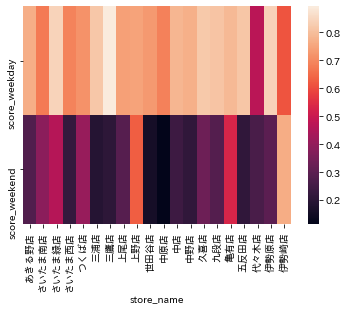

In [21]:
import seaborn as sns
import japanize_matplotlib
japanize_matplotlib.japanize()
sns.heatmap(pred_viz[:20].T)

### ノック７９：実績データを作成しよう

In [17]:
target_cols = ['store_name', 'order', 'order_fin', 'order_cancel', 'order_delivery',
       'order_takeout', 'order_weekday', 'order_weekend', 'delta_avg']
actual_data = actual_data[target_cols]
actual_cols = ['store_name']
rename_cols = [x + f'_{tg_ym}' for x in actual_data.columns if x != 'store_name']
actual_cols.extend(rename_cols)
actual_data.columns = actual_cols
actual_data.head(3)

,store_name,order_202003,order_fin_202003,order_cancel_202003,order_delivery_202003,order_takeout_202003,order_weekday_202003,order_weekend_202003,delta_avg_202003
0,あきる野店,1186,958,228,858,328,839,347,35.204593
1,さいたま南店,1553,1266,287,1145,408,1103,450,35.259084
2,さいたま緑店,1063,875,188,807,256,754,309,35.268571


### ノック８０：現場に向けたレポートを作成し出力しよう

In [18]:
pred.loc[pred['score_weekday'] >= 0.75,'オーダー予測 平日'] = '増加大'
pred.loc[(pred['score_weekday'] < 0.75)&(pred['score_weekday'] >= 0.5),'オーダー予測 平日'] = '増加'
pred.loc[(pred['score_weekday'] < 0.5)&(pred['score_weekday'] >= 0.25),'オーダー予測 平日'] = '減少'
pred.loc[pred['score_weekday'] < 0.25,'オーダー予測 平日'] = '減少大'

pred.loc[pred['score_weekend'] >= 0.75,'オーダー予測 休日'] = '増加大'
pred.loc[(pred['score_weekend'] < 0.75)&(pred['score_weekend'] >= 0.5),'オーダー予測 休日'] = '増加'
pred.loc[(pred['score_weekend'] < 0.5)&(pred['score_weekend'] >= 0.25),'オーダー予測 休日'] = '減少'
pred.loc[pred['score_weekend'] < 0.25,'オーダー予測 休日'] = '減少大'

In [19]:
report = pred[['store_name','オーダー予測 平日','オーダー予測 休日', 'score_weekday', 'score_weekend']]
report = pd.merge(report, actual_data , on='store_name', how='left')
report.head(3)

,store_name,オーダー予測 平日,オーダー予測 休日,score_weekday,score_weekend,order_202003,order_fin_202003,order_cancel_202003,order_delivery_202003,order_takeout_202003,order_weekday_202003,order_weekend_202003,delta_avg_202003
0,あきる野店,増加大,減少,0.769104,0.281333,1186,958,228,858,328,839,347,35.204593
1,さいたま南店,増加,減少,0.677146,0.387685,1553,1266,287,1145,408,1103,450,35.259084
2,さいたま緑店,増加大,減少,0.842885,0.463951,1063,875,188,807,256,754,309,35.268571
